In [391]:
import requests

import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from umap import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm

import xgboost as xgb

In [ ]:
#path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

In [332]:
#df_full = pd.read_csv(path + "\\Dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full = pd.read_csv("dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,release_date,release_year
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,2022-04-08,2022
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2021-04-30,2021
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,2021-03-17,2021
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,2018-08-10,2018
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,2017-02-03,2017


In [ ]:
#Add release date to dataset

'''release_dates = []
tracks = []
TOKEN = ""
header = {"Authorization" : f"Bearer  {TOKEN}"}
for id in tqdm(df_full['track_id']):
    if len(tracks) < 50:
        tracks.append(id)
        continue
    tracks.append(id)
    resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
    for x in resp.json()['tracks']:
        release_dates.append(x['album']['release_date'])
    tracks = []

resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
for x in resp.json()['tracks']:
    release_dates.append(x['album']['release_date'])

df_full['release_date'] = release_dates
df_full.to_csv('dataset.csv', index=True)'''


  0%|          | 50/81344 [00:00<01:31, 886.42it/s]


KeyError: 'tracks'

In [336]:
df_full.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
release_date         object
release_year          int64
dtype: object

In [337]:
#We can ignore theese missing values, we will not use theese variables for classification anyway
df_full.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
release_date        0
release_year        0
dtype: int64

In [338]:
#This variable is very noisy, and rarely correct
df_full = df_full.drop(columns=['time_signature']);

In [339]:
df_full['release_year'] = df_full['release_date'].str[:4].astype('int64')

In [340]:
df_full.loc[:, ['release_year', 'track_id']].groupby('release_year').count().sort_values('release_year')

,track_id
release_year,
0,158
1905,2
1913,1
1923,1
1925,7
...,...
2021,7501
2022,14482
2023,73


In [341]:
df_full = df_full.loc[df_full['release_year'] != 0]

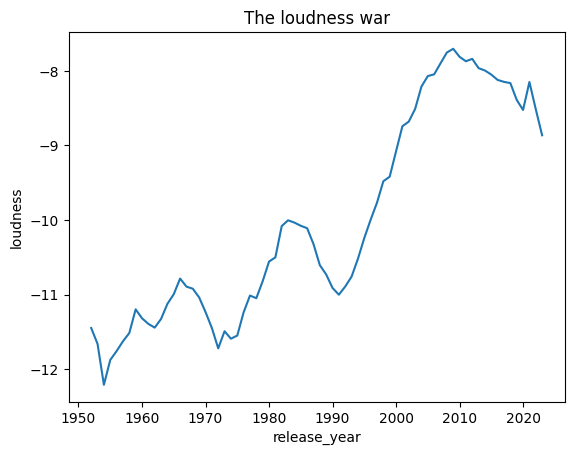

In [344]:
sns.lineplot(df_full.loc[df_full['release_year'] >= 1950].groupby('release_year')['loudness'].mean().rolling(window=5, center=True).mean().reset_index(), 
             x='release_year', 
             y='loudness',
             ).set_title("The loudness war");

In [375]:
genres_subset = ['singer-songwriter', 'death-metal', 'hard-rock', 'blues', 'hip-hop', 'country', 'folk', 'black-metal']
df_full = df_full.loc[lambda df: df['track_genre'].isin(genres_subset)].reset_index(drop=True)
NUM_OF_CLASSES = len(genres_subset)

In [346]:
df_full.loc[:, ['track_genre', 'track_id']].groupby('track_genre').count().sort_values('track_id')

,track_id
track_genre,
singer-songwriter,430
country,570
hard-rock,626
hip-hop,645
blues,686
folk,731
death-metal,878
black-metal,991


In [347]:
df_full.loc[:, ['track_genre', 'acousticness']].groupby('track_genre').mean().sort_values('acousticness', ascending=False)

,acousticness
track_genre,
singer-songwriter,0.571864
folk,0.484270
blues,0.327319
country,0.299410
hip-hop,0.222678
hard-rock,0.080543
black-metal,0.027299
death-metal,0.007201


In [348]:
df_full.loc[df_full['artists'] == 'Bob Dylan']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,release_date,release_year
1918,6HSXNV0b4M4cLJ7ljgVVeh,Bob Dylan,Pat Garrett & Billy The Kid (Soundtrack From T...,Knockin' On Heaven's Door,73,149880,False,0.513,0.3960,7,...,1,0.0299,0.251,0.177000,0.1100,0.229,140.208,country,1973-07-13,1973
1936,18GiV1BaXzPVYpp9rmOg0E,Bob Dylan,The Freewheelin' Bob Dylan,Blowin' in the Wind,68,165426,False,0.380,0.0993,2,...,1,0.0509,0.914,0.000023,0.0605,0.440,174.874,country,1963-05-27,1963
2108,3AhXZa8sUQht0UEdBJgpGc,Bob Dylan,Highway 61 Revisited,Like a Rolling Stone,70,369600,False,0.482,0.7210,0,...,1,0.0321,0.731,0.000000,0.1890,0.557,95.263,country,1965-08-30,1965
2187,3RkQ3UwOyPqpIiIvGVewuU,Bob Dylan,Bringing It All Back Home,Mr. Tambourine Man,64,330533,False,0.390,0.3100,5,...,1,0.0676,0.794,0.000000,0.3790,0.584,177.515,country,1965-03-22,1965
3801,52vA3CYKZqZVdQnzRrdZt6,Bob Dylan,The Times They Are A-Changin',The Times They Are A-Changin',67,192053,False,0.389,0.3960,7,...,1,0.0332,0.887,0.000000,0.0828,0.585,171.860,folk,1964-01-13,1964


In [349]:
df = df_full.drop(['track_id', 'artists', 'album_name', 'release_date', 'track_name', 'key'], axis=1)

In [350]:
label_encoder=LabelEncoder()

In [351]:
df['track_genre']=label_encoder.fit_transform(df['track_genre'])

df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,release_year
0,51,430733,False,0.428,0.972,-1.998,0,0.0666,0.000072,0.073600,0.0787,0.2250,118.306,0,2002
1,58,275205,True,0.250,0.952,-4.059,0,0.2090,0.000024,0.013500,0.0892,0.1260,143.022,0,2022
2,47,301285,False,0.468,0.913,-5.670,1,0.0720,0.026500,0.076900,0.0787,0.1870,109.003,0,2018
3,41,355474,False,0.144,0.466,-6.715,1,0.0522,0.686000,0.423000,0.0764,0.0737,87.290,0,2019
4,54,302360,False,0.462,0.905,-3.825,0,0.0438,0.000660,0.040200,0.0839,0.2530,122.925,0,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,72,286219,False,0.667,0.755,-7.246,1,0.0690,0.096600,0.000069,0.0523,0.8830,109.535,7,1976
5553,56,220866,False,0.536,0.355,-8.610,1,0.0259,0.733000,0.000012,0.1380,0.2200,139.888,7,2017
5554,42,269354,False,0.551,0.478,-10.580,0,0.0378,0.526000,0.000000,0.2880,0.5230,98.056,7,2022
5555,42,199285,False,0.646,0.645,-6.775,0,0.0287,0.246000,0.000000,0.1810,0.6870,121.999,7,2019


In [352]:
df_num = df.drop(columns=['track_genre'])

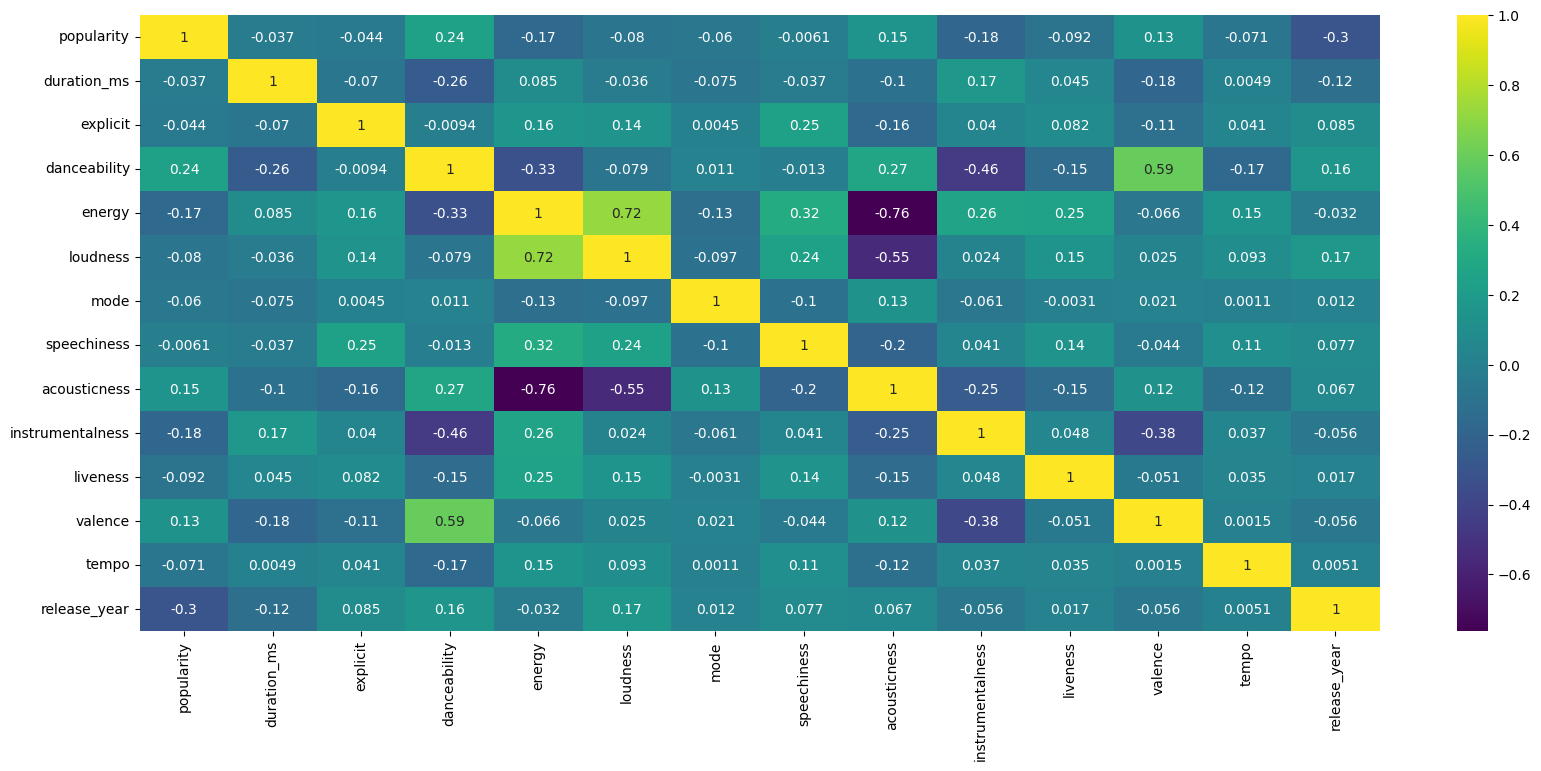

In [353]:
cor=df_num.corr()
plt.figure(figsize=(20,8))
sns.heatmap(cor, annot=True, cmap='viridis')
plt.show()

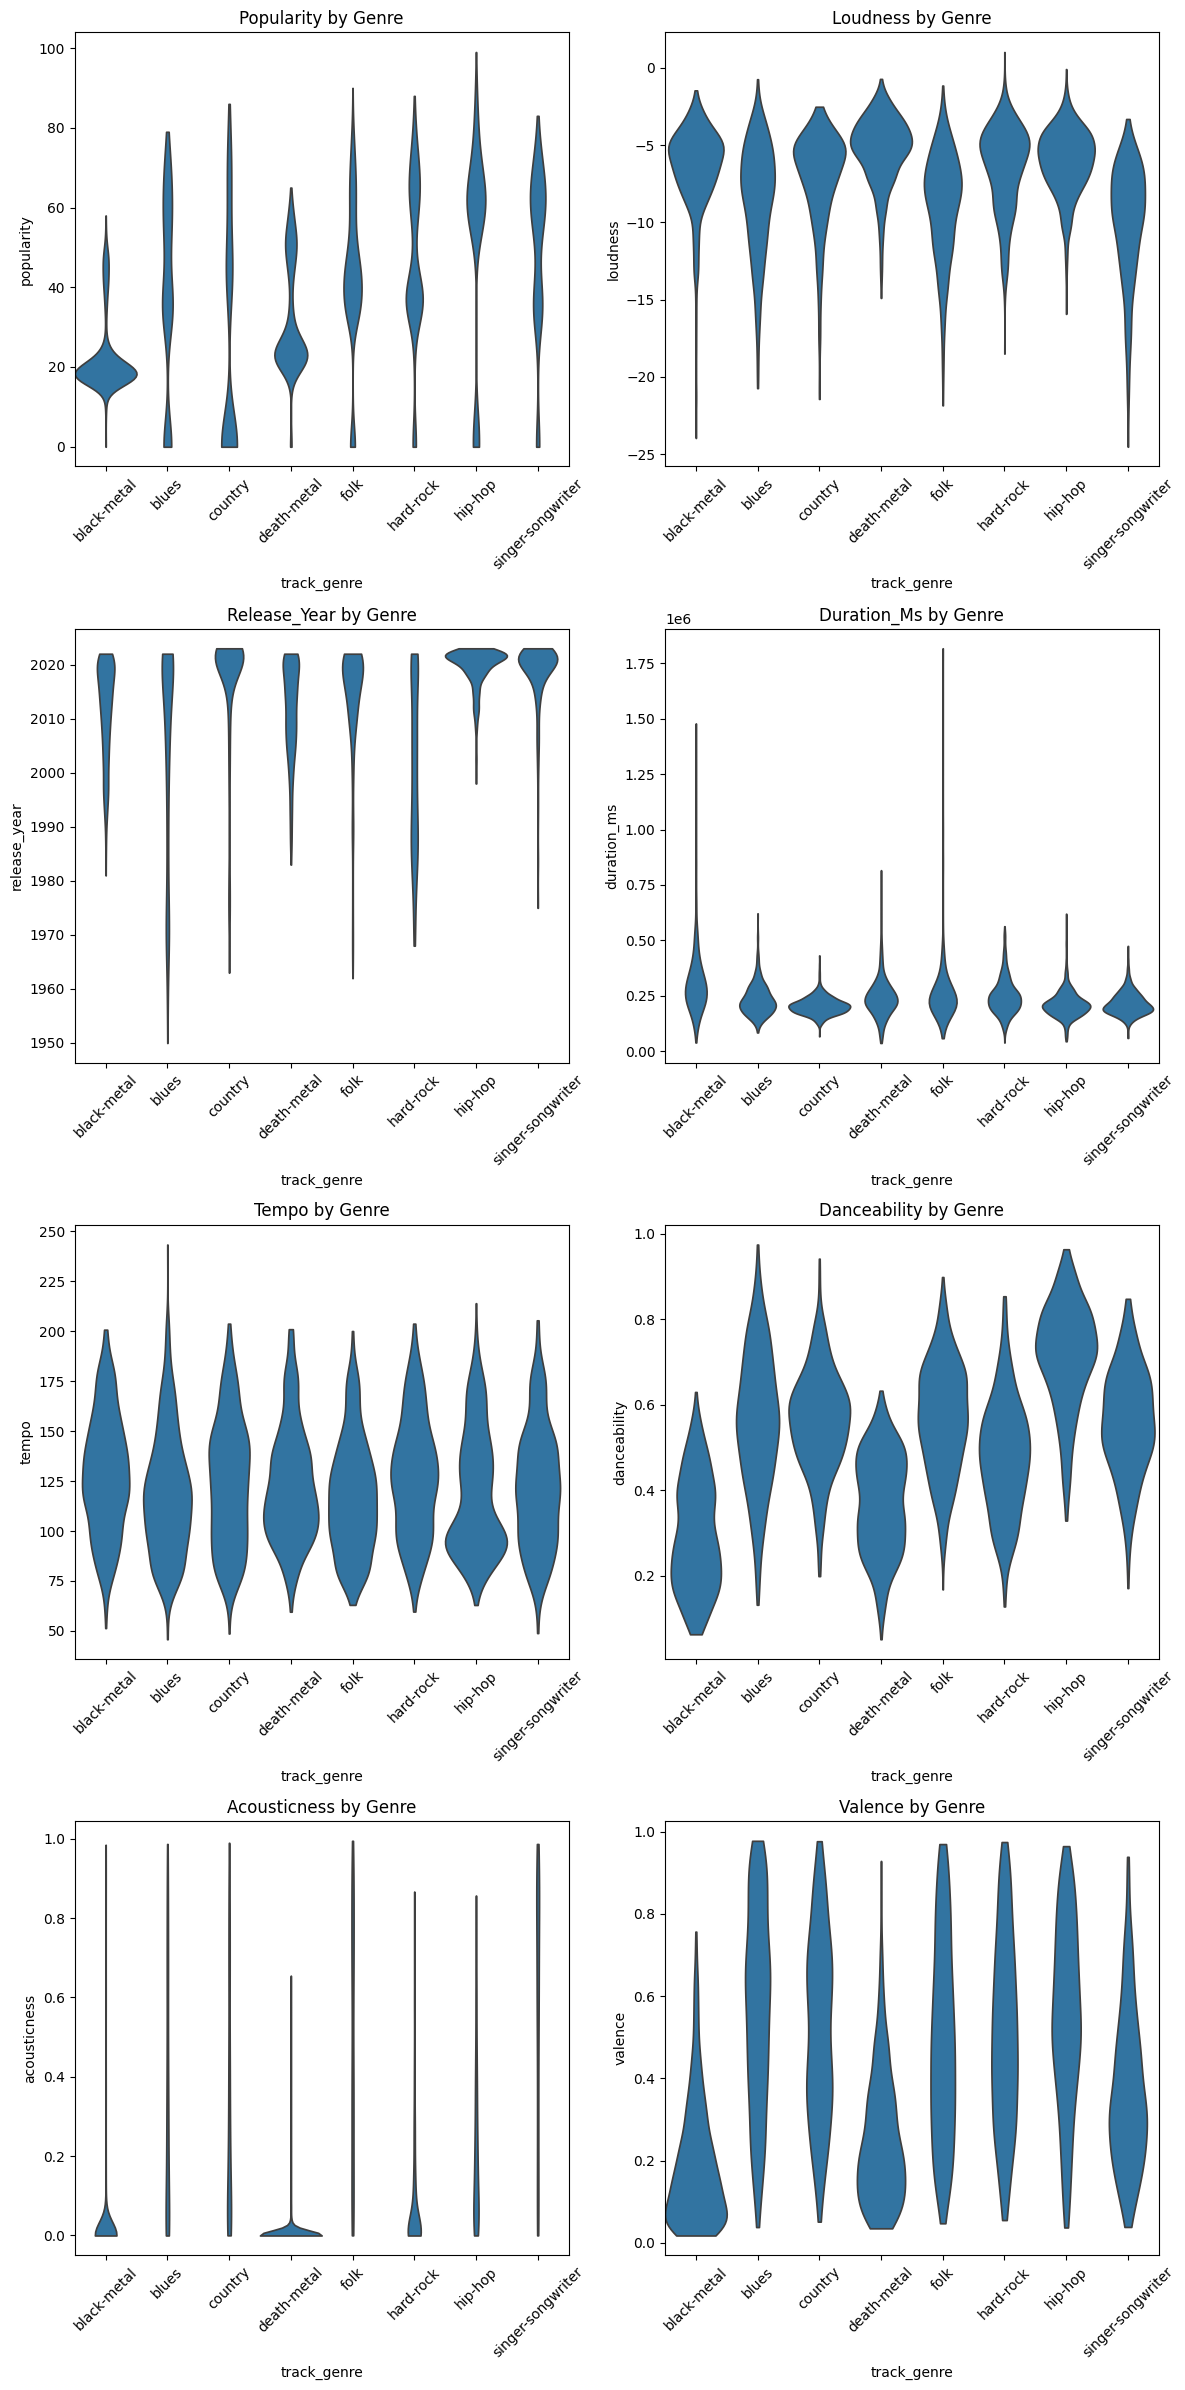

In [354]:
features = ['popularity', 'loudness', 'release_year', 'duration_ms', 'tempo', 'danceability', 'acousticness', 'valence']

# Create subplots
fig, axes = plt.subplots(nrows=int(len(features) / 2), ncols=2, figsize=(12, 24))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(df_full, x='track_genre', y=feature, inner=None, cut=0, width=1, ax=axes[i])
    axes[i].set_title(f'{feature.title()} by Genre')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [355]:
pd.DataFrame(df_full.loc[df_full.groupby('track_genre').idxmax().loc[:, 'popularity'].tolist()].loc[:, ['artists', 'track_name', 'popularity', 'track_genre']])

,artists,track_name,popularity,track_genre
1,Make Them Suffer,Doomswitch,58,black-metal
992,Cage The Elephant,Cigarette Daydreams,79,blues
1999,Morgan Wallen,You Proof,86,country
2254,Slayer,Raining Blood,65,death-metal
3138,Seafret,Atlantis,90,folk
3856,Ghost,Mary On A Cross,88,hard-rock
4961,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52",99,hip-hop
5130,Hozier,Take Me To Church,83,singer-songwriter


In [356]:
scaler = StandardScaler()
norm_df = df.copy()
norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year']])

C:\Users\jedrek656\AppData\Local\Temp\ipykernel_3060\1398707700.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.60001506 0.90577639 0.42529429 ... 0.20689334 0.20689334 0.99313677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year']])
C:\Users\jedrek656\AppData\Local\Temp\ipykernel_3060\1398707700.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.60208523  0.2280503   0.45845788 ...  0.17635878 -0.44267608
 -0.64085487]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year']] = scaler.fit_transform(df

In [357]:
X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=42)

In [358]:
X_train

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year
1392,0.687375,0.818744,False,0.549,0.294,-1.840275,0,0.0337,0.144000,0.798000,0.1080,0.145,-0.254515,-2.808050
2633,-0.579350,-0.248181,False,0.542,0.972,0.497300,1,0.0764,0.000013,0.000076,0.9780,0.222,-0.099435,0.716206
2574,-0.535670,-0.273572,False,0.430,0.934,1.179844,1,0.0493,0.000087,0.110000,0.0908,0.560,0.831643,-0.433008
1255,0.032173,0.199585,False,0.677,0.450,-1.241751,1,0.0250,0.780000,0.020500,0.1340,0.574,-1.201127,0.716206
4228,1.036817,-0.025257,False,0.601,0.928,0.848655,0,0.0481,0.014000,0.000113,0.1510,0.625,-0.231013,-0.049936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.273589,0.348802,False,0.554,0.830,1.187483,1,0.1520,0.379000,0.000000,0.2600,0.879,1.501966,0.716206
5191,-1.627675,-0.464984,False,0.681,0.690,-0.400334,1,0.0479,0.486000,0.000000,0.2390,0.904,1.101966,0.792820
5226,0.032173,-0.359542,False,0.682,0.383,-0.868399,1,0.0264,0.802000,0.000000,0.0761,0.295,-1.031046,0.792820
5390,0.818416,-0.476963,False,0.682,0.346,-0.707998,1,0.0781,0.682000,0.000000,0.2780,0.452,0.225092,0.639592


In [371]:
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train);

In [372]:
y_predict = classifier.predict(X_test)

In [373]:
print('Random forest classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Random forest classifier performance:
Accuracy score: 0.7068345323741008
F1 score: [0.85024155 0.55123675 0.68181818 0.7592068  0.59807074 0.6779661
 0.84328358 0.5323741 ]


In [379]:
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss',     
    use_label_encoder=False
)
classifier.fit(X_train, y_train);

e:\anaconda\envs\ML\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [380]:
y_predict = classifier.predict(X_test)

In [381]:
print('XGB classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

XGB classifier performance:
Accuracy score: 0.6987410071942446
F1 score: [0.84107579 0.55395683 0.65531915 0.76836158 0.61052632 0.66666667
 0.82397004 0.49382716]


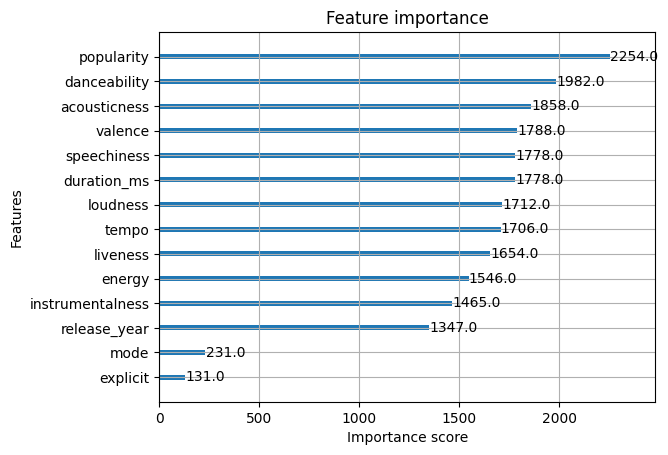

In [390]:
xgb.plot_importance(classifier);

In [394]:
classifier = GaussianNB()
classifier.fit(X_train, y_train);

In [395]:
y_predict = classifier.predict(X_test)

In [396]:
print('Naive Bayes classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Naive Bayes classifier performance:
Accuracy score: 0.5089928057553957
F1 score: [0.57910448 0.3562753  0.4695122  0.61320755 0.32407407 0.45933014
 0.67595819 0.42696629]
